<a href="https://colab.research.google.com/github/salmenhsairi/EndOfStudiesProjectNotebooks/blob/main/LayoutLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

In [ ]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

In [ ]:
from torch.nn import CrossEntropyLoss
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,SubsetRandomSampler
from transformers import LayoutLMForTokenClassification
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import os
import torch

import numpy as np
from sklearn.model_selection import KFold
import random

In [ ]:
%%bash
cd /content/
rm -r data
mkdir data
# mv *.zip data/dataset.zip 
# cp /content/drive/MyDrive/NERDatasets/EPIC_Case_Times_Extraction_ddvqdMl.zip data/dataset.zip 
cp /content/drive/MyDrive/NERDatasets/OCR_Invoice_Extraction_Tp4PlPQ.zip data/dataset.zip
# cp /content/drive/MyDrive/NERDatasets/250_rows_ocr_dataset_project.zip data/dataset.zip 
cd data && unzip -q dataset && rm dataset.zip
cd ..

In [ ]:
!mkdir data
!mv *.txt data

mkdir: cannot create directory ‘data’: File exists
mv: cannot stat '*.txt': No such file or directory


In [ ]:
# def generate_train_test_files(path,ratio):
#     file= os.path.join(path,"full_documents_IOB.txt")
#     data_sets = []
#     with open(file, 'r', encoding="utf8") as f:
#         lines = f.readlines()
#         print(len(lines))
#         first = True
#         txts , tags = [], []
#         for line in lines:
#             if (len(line.split('\t'))>0):
#                 if line =="-DOCSTART- -X- O O\n":
#                     if (first):
#                         first = False
#                         continue
#                     data_sets.append((txts,tags))
#                     txts , tags = [], []
#                 else:
#                     line=line.rstrip()
#                     try:
#                         tags.append(line.split('\t')[1])
#                         txts.append(line.split('\t')[0])
#                     except:
#                         pass
#         data_sets.append((txts,tags))
#     ratio = int(ratio)/100
#     print("this is the ratio of train / test :",ratio)
#     train, test = train_test_split(data_sets,test_size=ratio, random_state=2)
#     test_file = open(os.path.join(path,'test.tsv'), 'w', encoding="utf8")
#     train_file = open(os.path.join(path,'train.tsv'), 'w', encoding="utf8")
#     for tr in train:
#         train_file.write("-DOCSTART- -X- O O\n")
#         for xtr , ytr in zip(tr[0],tr[1]) :
#             train_file.write(xtr+'\t'+ytr+'\n')
#     for ts in test :
#         test_file.write("-DOCSTART- -X- O O\n")
#         for xts , yts in zip(ts[0],ts[1]) :
#             test_file.write(xts+'\t'+yts+'\n')
#     test_file.close()
#     train_file.close()

In [ ]:
# generate_train_test_files('/content/data',20)

In [ ]:
#generating test and train iob files
test_size = 0.0
os.chdir('/content/data/')
iob_files = os.listdir()
# os.makedirs('/content/data/train',exist_ok=True)
# os.makedirs('/content/data/test',exist_ok=True)

for f in iob_files :
  if f.endswith('.txt') and not(f.endswith('box.txt') or f.endswith('image.txt') or f.endswith('labels.txt')):
    with open(f,'r',encoding='utf8') as iob_img:
      doc_imgs = iob_img.read().split('\n\n')
      # train,test = train_test_split(doc_imgs,test_size=test_size,shuffle=False)
      with open('/content/data/train.txt','w',encoding='utf8') as train_file:
        for element in doc_imgs:
          train_file.write(element+'\n\n')
      # with open('/content/data/test.txt','w',encoding='utf8') as test_file:
      #   for element in test:
      #     test_file.write(element+'\n\n')
  if f.endswith('image.txt'):
    with open(f,'r',encoding='utf8') as iob_img:
      doc_imgs = iob_img.read().split('\n\n')
      # train,test = train_test_split(doc_imgs,test_size=test_size,shuffle=False)
      with open('/content/data/train_image.txt','w',encoding='utf8') as train_file:
        for element in doc_imgs:
          train_file.write(element+'\n\n')
      # with open('/content/data/test_image.txt','w',encoding='utf8') as test_file:
      #   for element in test:
      #     test_file.write(element+'\n\n')
  if f.endswith('box.txt'):
    with open(f,'r',encoding='utf8') as iob_img:
      doc_imgs = iob_img.read().split('\n\n')
      # train,test = train_test_split(doc_imgs,test_size=test_size,shuffle=False)
      with open('/content/data/train_box.txt','w',encoding='utf8') as train_file:
        for element in doc_imgs:
          train_file.write(element+'\n\n')
      # with open('/content/data/test_box.txt','w',encoding='utf8') as test_file:
      #   for element in test:
      #     test_file.write(element+'\n\n')


In [ ]:
# rm /content/data/*.txt

In [ ]:
def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("/content/data/7019d71d-167e-473b-91ac-b56fc4d496e8\\7019d71d-167e-473b-91ac-b56fc4d496e8_labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

In [ ]:
args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=1)

# eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
# eval_sampler = SequentialSampler(eval_dataset)
# eval_dataloader = DataLoader(eval_dataset,
#                              sampler=eval_sampler,batch_size=1)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

In [ ]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

In [ ]:
print(len(train_dataloader))
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)

51


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [ ]:
model.num_parameters()

In [ ]:
# !zip -r data.zip /content/data
# eval_dataloader = train_dataloader

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
# put model in evaluation mode
def eval_model(return_entity_metrics=False):
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  model.eval()
  for batch in tqdm(eval_dataloader, desc="Evaluating"):
      with torch.no_grad():
          input_ids = batch[0].to(device)
          bbox = batch[4].to(device)
          attention_mask = batch[1].to(device)
          token_type_ids = batch[2].to(device)
          labels = batch[3].to(device)

          # forward pass
          outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                          labels=labels)
          # get the loss and logits
          tmp_eval_loss = outputs.loss
          logits = outputs.logits

          eval_loss += tmp_eval_loss.item()
          nb_eval_steps += 1

          # compute the predictions
          if preds is None:
              preds = logits.detach().cpu().numpy()
              out_label_ids = labels.detach().cpu().numpy()
          else:
              preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
              out_label_ids = np.append(
                  out_label_ids, labels.detach().cpu().numpy(), axis=0
              )

  # compute average evaluation loss
  eval_loss = eval_loss / nb_eval_steps
  preds = np.argmax(preds, axis=2)

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != pad_token_label_id:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "loss": eval_loss,
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  if return_entity_metrics:
    print(classification_report(out_label_list, preds_list))
  return results

In [ ]:
foldperf = dict()
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):
  #reset the model to prevent overfitting
  model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
  tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
  optimizer = AdamW(model.parameters(), lr=5e-5)
  model.to(device)
  print('Fold {}'.format(fold + 1))
  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(val_idx)
  train_dataloader = DataLoader(train_dataset, batch_size=1, sampler=train_sampler)
  eval_dataloader = DataLoader(train_dataset, batch_size=1, sampler=test_sampler)
  global_step = 0
  num_train_epochs = 10
  t_total = len(train_dataloader) * num_train_epochs # total number of training steps
  # training_stats = []
  history = {'train_loss': [], 'eval_loss': [],'F1-score':[]}
  #put the model in training mode
  model.train()
  for epoch in range(num_train_epochs):
    train_loss = 0
    tk0 = tqdm(train_dataloader, total = len(train_dataloader),desc='Training')
    for bi,batch in enumerate(tk0):
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)
        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        # print loss every 100 steps
        # if global_step % 100 == 0:
        #   print(f"Loss after {global_step} steps: {loss.item()}")
        # backward pass to get the gradients 
        loss.backward()
        # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
    eval_results = eval_model()
    epoch_stat = {'epoch':epoch+1,'eval_loss':eval_results['loss'],'train_loss':train_loss/len(train_dataloader),'F1-score':eval_results['f1']}
    print(epoch_stat)
    history['train_loss'].append(train_loss/len(train_dataloader))
    history['eval_loss'].append(eval_results['loss'])
    history['F1-score'].append(eval_results['f1'])
  history['precision'] = eval_model()['precision']
  history['recall'] = eval_model()['recall']
  foldperf['fold{}'.format(fold+1)] = history

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 1


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.6750172475973765, 'train_loss': 1.0942069278823006, 'F1-score': 0}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.6643069187800089, 'train_loss': 0.743701375524203, 'F1-score': 0}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.5976709574460983, 'train_loss': 0.7032400336530473, 'F1-score': 0}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.48558292786280316, 'train_loss': 0.5563199907541275, 'F1-score': 0.03846153846153846}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.3401303216814995, 'train_loss': 0.37031360566616056, 'F1-score': 0.4158415841584159}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.2812274321913719, 'train_loss': 0.23047945044106907, 'F1-score': 0.6808510638297872}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.26065611218412715, 'train_loss': 0.14127850520114105, 'F1-score': 0.7070707070707072}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.25152580564220745, 'train_loss': 0.09196752543664641, 'F1-score': 0.7010309278350516}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.28291019300619763, 'train_loss': 0.059297228211330044, 'F1-score': 0.6744186046511628}


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.2478512991219759, 'train_loss': 0.05770614826016956, 'F1-score': 0.7157894736842104}


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 2


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.7373849391937256, 'train_loss': 1.0835912217912467, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.5939388036727905, 'train_loss': 0.7136581021806468, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.4657693564891815, 'train_loss': 0.5639870299593263, 'F1-score': 0.05128205128205127}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.31973921656608584, 'train_loss': 0.36823252750479657, 'F1-score': 0.3846153846153846}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.20253187716007232, 'train_loss': 0.22017669531962145, 'F1-score': 0.725}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.24251380562782288, 'train_loss': 0.14318842100708382, 'F1-score': 0.7529411764705882}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.218993903696537, 'train_loss': 0.08818040397423117, 'F1-score': 0.8333333333333333}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.2276243031024933, 'train_loss': 0.05894050431316313, 'F1-score': 0.7901234567901234}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.24376236349344255, 'train_loss': 0.03398957183463094, 'F1-score': 0.8292682926829269}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.2566652536392212, 'train_loss': 0.022773200625796682, 'F1-score': 0.8500000000000001}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 3


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.8250926017761231, 'train_loss': 1.0592417107976002, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.717328953742981, 'train_loss': 0.663762050802293, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.49617634415626527, 'train_loss': 0.500142033657302, 'F1-score': 0.029411764705882353}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.39262627959251406, 'train_loss': 0.3403548596669798, 'F1-score': 0.3165467625899281}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.32801711559295654, 'train_loss': 0.22122861299177873, 'F1-score': 0.4745762711864407}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.2712075859308243, 'train_loss': 0.14810677589443716, 'F1-score': 0.5483870967741935}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.1953587830066681, 'train_loss': 0.1028721617008357, 'F1-score': 0.6728971962616822}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.20304595082998275, 'train_loss': 0.07543690196926826, 'F1-score': 0.7454545454545455}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.1865912139415741, 'train_loss': 0.06408978583615112, 'F1-score': 0.6415094339622641}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.20484785884618759, 'train_loss': 0.05990524869412184, 'F1-score': 0.6833333333333333}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 4


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.6794912815093994, 'train_loss': 1.0935356753027958, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.5287269741296768, 'train_loss': 0.7014983555544978, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.46319560110569, 'train_loss': 0.5602998017616894, 'F1-score': 0.3111111111111111}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.39218118190765383, 'train_loss': 0.3842397983307424, 'F1-score': 0.48484848484848486}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.3288996398448944, 'train_loss': 0.26024225370391557, 'F1-score': 0.6666666666666667}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.32397568225860596, 'train_loss': 0.16729960817357767, 'F1-score': 0.6588235294117647}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.2631867066025734, 'train_loss': 0.1035925792530179, 'F1-score': 0.704225352112676}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.27619292587041855, 'train_loss': 0.07605155458187927, 'F1-score': 0.775}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.2863713677972555, 'train_loss': 0.053073789671306375, 'F1-score': 0.7160493827160495}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.33399889022111895, 'train_loss': 0.0378198076505214, 'F1-score': 0.7209302325581395}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 5


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.5993239521980286, 'train_loss': 1.0940924001776653, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.5065693438053132, 'train_loss': 0.7220211550593376, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.3869145542383194, 'train_loss': 0.5806394141653309, 'F1-score': 0.1818181818181818}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.2823657512664795, 'train_loss': 0.38197254486705945, 'F1-score': 0.47191011235955055}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.18195887953042983, 'train_loss': 0.22605558209445165, 'F1-score': 0.5977011494252874}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.17141467481851577, 'train_loss': 0.14977176787088747, 'F1-score': 0.6521739130434782}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.15905854478478432, 'train_loss': 0.08930217189228405, 'F1-score': 0.7173913043478262}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.15405343882739544, 'train_loss': 0.0767178626569069, 'F1-score': 0.7333333333333334}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.1581101890653372, 'train_loss': 0.05646634888430328, 'F1-score': 0.7816091954022989}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.16549769453704358, 'train_loss': 0.04283001979448549, 'F1-score': 0.7727272727272727}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 6


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.953980314731598, 'train_loss': 1.042500791342362, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.9238934397697449, 'train_loss': 0.712349754312764, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.7909341752529144, 'train_loss': 0.5899557620286942, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.67536661028862, 'train_loss': 0.4105432334801425, 'F1-score': 0.12698412698412698}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.6599919706583023, 'train_loss': 0.2440999116262664, 'F1-score': 0.32558139534883723}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.6571375876665115, 'train_loss': 0.1475230534358517, 'F1-score': 0.38202247191011235}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.6314411863684655, 'train_loss': 0.10375045150842356, 'F1-score': 0.43678160919540227}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.6602578938007355, 'train_loss': 0.07052794297266265, 'F1-score': 0.4047619047619048}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.6618721723556519, 'train_loss': 0.05216239662031117, 'F1-score': 0.4578313253012048}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.6367145888507366, 'train_loss': 0.04415225533201643, 'F1-score': 0.48484848484848486}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 7


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.7871512591838836, 'train_loss': 1.0832960424215898, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.7842124819755554, 'train_loss': 0.7339299554410188, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.7541323602199554, 'train_loss': 0.728341529874698, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.6053283751010895, 'train_loss': 0.6515719443559647, 'F1-score': 0.08}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.4578405112028122, 'train_loss': 0.4655015957744225, 'F1-score': 0.31034482758620685}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.4126465618610382, 'train_loss': 0.2635721308381661, 'F1-score': 0.4761904761904763}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.34305098056793215, 'train_loss': 0.15689060075775438, 'F1-score': 0.5277777777777778}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.33939250707626345, 'train_loss': 0.10401643924010189, 'F1-score': 0.547945205479452}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.2837864883244038, 'train_loss': 0.07088947194911864, 'F1-score': 0.675}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.3098819747567177, 'train_loss': 0.053233260167357715, 'F1-score': 0.631578947368421}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 8


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.6737475454807281, 'train_loss': 1.0673169568181038, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.5336831599473953, 'train_loss': 0.658935340202373, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.37817569375038146, 'train_loss': 0.46756332367658615, 'F1-score': 0.3055555555555555}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.3002272337675095, 'train_loss': 0.27135302725693455, 'F1-score': 0.4578313253012048}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.29893805235624316, 'train_loss': 0.1875816322863102, 'F1-score': 0.6097560975609756}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.2473982408642769, 'train_loss': 0.1110881571860417, 'F1-score': 0.6382978723404256}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.26824475936591624, 'train_loss': 0.07977302182141853, 'F1-score': 0.7045454545454546}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.256826538965106, 'train_loss': 0.051210702386806195, 'F1-score': 0.6451612903225806}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.2581595445051789, 'train_loss': 0.037086715324498386, 'F1-score': 0.7368421052631579}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.25971940914168956, 'train_loss': 0.029509776433848816, 'F1-score': 0.723404255319149}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 9


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.7264766454696655, 'train_loss': 1.0849193386409595, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.6917071044445038, 'train_loss': 0.703430560943873, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.5613926202058792, 'train_loss': 0.584393969696501, 'F1-score': 0.11320754716981131}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.45526887774467467, 'train_loss': 0.3935307137992071, 'F1-score': 0.41025641025641024}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.42296505272388457, 'train_loss': 0.2459555929121764, 'F1-score': 0.4722222222222222}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.4284667193889618, 'train_loss': 0.146194105643941, 'F1-score': 0.5925925925925926}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.475522980093956, 'train_loss': 0.09489702772470596, 'F1-score': 0.5393258426966292}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.4075312167406082, 'train_loss': 0.06963140222891841, 'F1-score': 0.6}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.3970039516687393, 'train_loss': 0.045817314272584474, 'F1-score': 0.6666666666666666}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.4823066622018814, 'train_loss': 0.03231767740141114, 'F1-score': 0.6506024096385542}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Fold 10


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 1, 'eval_loss': 0.779303902387619, 'train_loss': 1.0570504402984744, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 2, 'eval_loss': 0.5421717882156372, 'train_loss': 0.6800500079989433, 'F1-score': 0}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 3, 'eval_loss': 0.30517873764038084, 'train_loss': 0.48666681478852813, 'F1-score': 0.5283018867924528}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 4, 'eval_loss': 0.19858450889587403, 'train_loss': 0.29309139919021854, 'F1-score': 0.7945205479452055}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 5, 'eval_loss': 0.1574942335486412, 'train_loss': 0.17365969879471738, 'F1-score': 0.7297297297297296}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 6, 'eval_loss': 0.1053944256156683, 'train_loss': 0.11438200266464897, 'F1-score': 0.8405797101449276}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 7, 'eval_loss': 0.10118433237075805, 'train_loss': 0.08850550920823994, 'F1-score': 0.8947368421052632}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 8, 'eval_loss': 0.11073345169425011, 'train_loss': 0.07903156634015233, 'F1-score': 0.8307692307692307}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 9, 'eval_loss': 0.16619693208485842, 'train_loss': 0.05072449818860902, 'F1-score': 0.8857142857142857}


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

{'epoch': 10, 'eval_loss': 0.124922507815063, 'train_loss': 0.04971309306869364, 'F1-score': 0.8611111111111112}


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import gc
gc.collect()

1006

In [ ]:
eval_model(return_entity_metrics=True)

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

                precision    recall  f1-score   support

           TTC       1.00      0.71      0.83         7
    INVOICE_ID       1.00      1.00      1.00         3
       DATA_ID       1.00      1.00      1.00         3
        TTC_ID       0.83      0.71      0.77         7
 MONTANT_HT_ID       1.00      1.00      1.00         2
        SELLER       0.67      1.00      0.80         4
          DATE       0.80      1.00      0.89         4
INVOICE_NUMBER       0.75      1.00      0.86         3
    MONTANT_HT       1.00      1.00      1.00         2

     micro avg       0.84      0.89      0.86        35
     macro avg       0.88      0.89      0.87        35



{'f1': 0.8611111111111112,
 'loss': 0.124922507815063,
 'precision': 0.8378378378378378,
 'recall': 0.8857142857142857}

In [ ]:
# import pandas as pd
# pd.DataFrame(foldperf['fold3'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


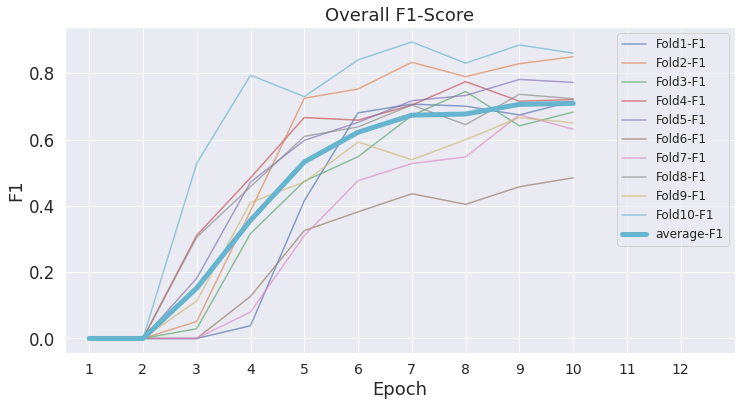

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

# Display floats with two decimal places.
pd.set_option('precision', 2)
df_stats = [pd.DataFrame(foldperf[fold]) for fold in foldperf.keys() ]
# df_stats = df_stats.set_index('epoch')
# df_stats

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
for j,df_stat in enumerate(df_stats):
  # plt.plot(df_stat['train_loss'], f'C{j}-o', label=f"Fold{j+1}-Training",alpha=0.65)
  # plt.plot(df_stat['eval_loss'], f'C{j}-X', label=f"Fold{j+1}-Validation",alpha=0.65)
  plt.plot(df_stat['F1-score'], f'C{j}', label=f"Fold{j+1}-F1",alpha=0.65)

# average_train_loss = []
# average_valid_loss = [] 
average_f1 = []
for i in range(num_train_epochs):
  # epoch_train_losses = [df_stat['train_loss'].iloc[i] for df_stat in df_stats]
  # epoch_valid_losses = [df_stat['eval_loss'].iloc[i] for df_stat in df_stats]
  epoch_f1s = [df_stat['F1-score'].iloc[i] for df_stat in df_stats]
  # epoch_average_train_loss = sum(epoch_train_losses)/len(epoch_train_losses)
  # epoch_average_valid_loss = sum(epoch_valid_losses)/len(epoch_valid_losses)
  epoch_average_f1 = sum(epoch_f1s)/len(epoch_f1s)
  # average_train_loss.append(epoch_average_train_loss)
  # average_valid_loss.append(epoch_average_valid_loss)
  average_f1.append(epoch_average_f1)
# plt.plot(average_train_loss, f'C{j+1}', label=f"average-training",linewidth=5)
# plt.plot(average_valid_loss, f'C{j+2}', label=f"average-validation",linewidth=5)
plt.plot(average_f1, f'C', label=f"average-F1",linewidth=5)
# Label the plot.
plt.title("Overall F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend(fontsize=12)
plt.xticks(np.arange(13),np.arange(1,13),fontsize=14)

plt.show()

In [ ]:
precisions = []
recalls = []
for i,fold in enumerate(foldperf):
  precisions.append(foldperf[fold]['precision'])
  recalls.append(foldperf[fold]['recall'])
print(f'cross_validation_precision : {sum(precisions)/len(precisions)}')
print(f'cross_validation_recall : {sum(recalls)/len(recalls)}')

cross_validation_precision : 0.7260838883641256
cross_validation_recall : 0.7080547029815751


In [ ]:

#save the model
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/Work/LayoutLMModel/model.pth')

In [ ]:
#load the model
model= torch.load('/content/drive/MyDrive/Colab Notebooks/Work/LayoutLMModel/model.pth',map_location=device)

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,798 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont

#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/4d90a926-7b79-4457-800f-f6621b82dda7_2021-05-25_0805.txt_image_0.jpg")
image = image.convert("RGB")
image

In [ ]:
# import pytesseract
# from pytesseract import Output
# pytesseract.image_to_data(image, output_type=Output.DICT)['text']

In [ ]:
import numpy as np

width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
            
ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df[:20]

In [ ]:
len(ocr_df)

172

In [ ]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes

In [ ]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [ ]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [ ]:
# raw_text = tokenizer.decode(input_ids)
# ids = input_ids
tokenizer.decode(input_ids)

In [ ]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

In [ ]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

In [ ]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

In [ ]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

In [ ]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

In [ ]:
print(outputs.logits.shape)
print(outputs.logits)

In [ ]:
preds = outputs.logits.argmax(-1)
print(outputs)
print(preds.shape)

In [ ]:
# for i,w in enumerate(words):
#   if int(preds[0][i]) != 30:
#     print((w,label_map[int(preds[0][i])]))

In [ ]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level
print(token_predictions)

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
final_tokens = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)
    final_tokens.append(id)

# for id, prediction in zip(input_ids.squeeze().tolist(), predictions):
#   if id != 0:
#     print(tokenizer.decode([id]), label_map[prediction])
print(word_level_predictions)

In [ ]:
print(len(word_level_predictions))

203


In [ ]:
print(len(final_boxes))

203


In [ ]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'data_id':'rgb(215,22,150)', 'date':'rgb(12,123,200)', 'invoice_id':'rgb(120,150,255)','invoice_number':'rgb(120,12,230)',
               'montant_ht_id':'rgb(255,255,12)','montant_ht':'rgb(12,216,216)','seller':'rgb(255,25,155)','ttc':'rgb(255,150,120)',
               'ttc_id':'rgb(0,0,255)','tva':'rgb(0,255,0)','tva_id':'rgb(255,0,255)','other':'rgb(255,0,0)'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    if predicted_label != 'other':
      draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
image

In [ ]:
doc_text = ' '.join(words)
doc_text

In [ ]:
labels_boxes = [(tokenizer.decode([x]),label_map[y],b) for (x,y,b) in zip(final_tokens,word_level_predictions,final_boxes) if label_map[y] != 'O']

In [ ]:
labels_boxes

[(',', 'E-INVOICE_ID', [170, 62, 222, 70]),
 ('volkswagen', 'B-SELLER', [133, 38, 205, 45]),
 ('no', 'E-INVOICE_ID', [120, 124, 137, 132]),
 ('740', 'S-INVOICE_NUMBER', [142, 124, 193, 131]),
 ('.', 'E-INVOICE_ID', [158, 241, 178, 248])]

In [ ]:
annots = []
for (tok,tag,box) in labels_boxes:
  word_map = {}
  row = ocr_df[(ocr_df.left == box[0]) & (ocr_df.top == box[1]) & (ocr_df.width == box[2]-box[0]) & (ocr_df.height == box[3]-box[1])]
  txt = row['text'].tolist()[0]
  word_map['text'] = txt 
  word_map['position'] = box
  word_map['label'] = tag
  word_map['start'] = doc_text.find(txt)+1
  word_map['end'] = word_map['start'] + len(txt)
  annots.append(word_map)
annots

In [ ]:
# labels = {x:label_map[y] for (x,y) in zip(final_tokens,word_level_predictions) if label_map[y] != 'O'}

# def get_word_tokens(word):
#   special_ids = [tokenizer.cls_token_id,tokenizer.sep_token_id,tokenizer.pad_token_id]
#   word_tokens = tokenizer.tokenize(word)
#   word_ids = [tokenizer.encode(wt) for wt in word_tokens]
#   final_ids = []
#   for sub_word in word_ids:
#     for id in sub_word:
#       if (id in special_ids) or tokenizer.decode([id]).startswith("##") or tokenizer.decode([id]) == '#' :
#         continue
#       else:
#         final_ids.append(id)
#   return final_ids

In [ ]:
# doc_labels = {}
# for w in  doc_text.split():
#   w_ids = set(get_word_tokens(w))
#   inter = w_ids.intersection(labels.keys())
#   if inter == set():
#     continue
#   else:
#     doc_labels[w] = labels[list(inter)[0]]
# doc_labels = {v: k for k, v in doc_labels.items()}
# doc_labels

In [ ]:
# annot_maps = []
# for k,w in doc_labels.items():
#   word_map = {}
#   word_map['start'] = doc_text.find(w)
#   word_map['end'] =  word_map['start'] + len(w)
#   word_map['label'] = k
#   word_map['text'] = w
#   annot_maps.append(word_map)

In [ ]:
import json
dictionary = {"document": doc_text , "annotation": annots}
with open("sample.json", "w") as outfile:
    json.dump(dictionary, outfile)

In [ ]:
with open("sample.json", "r") as f:
  json_object = json.load(f)
    
print(json_object)
print(type(json_object))

In [ ]:
json_object

In [ ]:
# raw_tokens = tokenizer.decode(input_ids)

In [ ]:
# special_ids = [tokenizer.cls_token_id,tokenizer.sep_token_id,tokenizer.pad_token_id]
# special_tokens = [tokenizer.decode([id]) for id in special_ids ]
# tokens_list = raw_tokens.split()
# edited_tokens = ' '.join([token for token in tokens_list if token not in special_tokens])